In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from sklearn.datasets import load_iris
from scipy import stats
from sklearn.mixture import GaussianMixture

In [55]:
class myGMM():
    ''' 复现混合高斯模型代码

    参数
    --------------------
    n_clusters : int, default=3
        聚类个数以及选择中心点的个数

    max_iter : int, default=100
        一次聚类的迭代次数
    
    tol : float, default=1e-4
        收敛条件

    init : str, default='random_from_data'
        初始点的选择
    '''
    mu : np.ndarray
    sigma : np.ndarray
    pi : np.ndarray
    

    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, init='random_from_data') -> None:
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.norms = [None for i in range(n_clusters)]
        self.labels_ = []


    def _density(self, x, mu, sigma):
        ''' 多元正态分布的密度函数

        参数
        --------------------
        x : ndarray of shape (n_features, )
            数据点

        mu : ndarray of shape (n_features, )
            均值向量

        sigma : ndarray of shape (n_features, n_features)
            协方差矩阵

        返回 
        --------------------
        density : float
            密度值
        '''
        norm = stats.multivariate_normal(mu, sigma)
        return norm.pdf(x)


    def fit(self, X):
        '''计算聚类结果
        
        参数
        --------------------
        X : ndarray of shape (n_samples, n_features)
            数据点

        返回
        --------------------
        self : object
            Fitted estimator.
        '''

        n_samples, n_features = X.shape

        # 初始化均值和协方差
        if self.init == 'random_from_data':
            idx = np.random.randint(0, n_samples-1, self.n_clusters)
            self.mu = X[idx, :]
        else:
            self.mu = np.random.randn(self.n_clusters, n_features)
        self.sigma = np.empty((self.n_clusters, n_features, n_features))
        for i in range(self.n_clusters):                  # 随机生成协方差矩阵，必须是半正定矩阵
            self.sigma[i] = np.eye(n_features) * np.random.rand(1) * self.n_clusters
        self.pi = np.random.randn(self.n_clusters)
        self.pi /= np.sum(self.pi)

        try: 
            for iter in range(self.max_iter):
                new_pi = np.empty((n_samples, self.n_clusters))
                # 计算个体的类别概率期望
                for i in range(n_samples):
                    for k in range(self.n_clusters):
                        new_pi[i][k] = self.pi[k] * self._density(X[i], self.mu[k], self.sigma[k])
                new_pi = (new_pi.T / np.sum(new_pi, axis=1)).T
                
                if np.sum((self.pi - new_pi) ** 2) < self.tol ** 2:
                    break


                # 更新参数
                flag = 0
                for k in range(self.n_clusters):
                    fenmu = np.sum(new_pi[:, k])
                    fenzi = np.zeros((1, n_features))
                    for i in range(n_samples):
                        fenzi += new_pi[i][k] * X[i]

                    new_mu = fenzi / fenmu
                    # if np.sum((new_mu - self.mu[k]) ** 2, axis=1) < self.tol ** 2:
                    #     flag = 1
                    #     break
                    self.mu[k] = fenzi / fenmu


                for k in range(self.n_clusters):
                    fenmu = np.sum(new_pi[:, k])
                    fenzi = np.zeros((n_features, n_features))
                    for i in range(n_samples):
                        tmp = np.reshape(X[i] - self.mu[k], (-1, 1))
                        fenzi += new_pi[i][k] * tmp @ tmp.T
                    
                    new_sigma = fenzi / fenmu
                    # if np.sum((new_sigma - self.sigma[k]) ** 2) < self.tol ** 2:
                    #     flag = 1
                    #     break
                    self.sigma[k] = fenzi / fenmu
                
                self.pi[k] =  np.sum(new_pi[:, k]) / n_samples

                for i in range(self.n_clusters):
                    self.norms[i] = stats.multivariate_normal(self.mu[i], self.sigma[i])
            
        except:
            pass
        
        

        return self
    

    def fit_predict(self, X):
        '''预测数据点的标签值
        
        参数
        --------------------
        X : ndarray of shape (n_samples, n_features)
            数据点

        返回
        --------------------
        labels_ : ndarray of shape (n_samples,)
            预测标签
        '''

        n_samples, n_features = X.shape

        for i in range(n_samples):
            probs = []
            for k in range(self.n_clusters):
                try:
                    tmp = self._density(X[i], self.mu[k], self.sigma[k])
                    probs.append(tmp)
                except:
                    probs.append(1)

            probs = np.array(probs)

            self.labels_.append(np.argmax(probs))
        
        return self.labels_
            

In [3]:
iris_dataset = load_iris()
data = iris_dataset["data"][:, :2]
K = 3

In [59]:
model = myGMM(max_iter=1000)

model.fit(data)

result = model.fit_predict(data)
result = np.array(result)

In [60]:
print(result)

[2 2 2 2 0 0 0 2 2 2 2 0 2 0 2 0 0 2 2 0 2 0 0 2 0 2 2 2 2 2 2 2 0 0 2 2 2
 0 0 2 2 1 0 2 0 2 0 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


[]

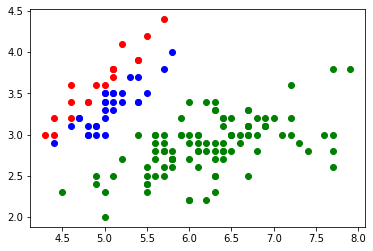

In [61]:
color = ["red", "green", "blue"]
for i in range(K):
    plt.scatter(data[result == i][:, 0], data[result == i][:, 1], color=color[i])
plt.plot()

[]

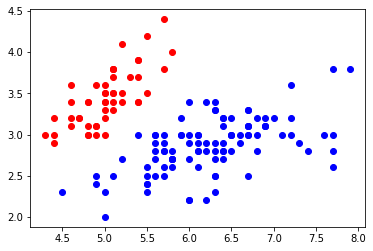

In [62]:
model_true = GaussianMixture(n_components=3, init_params='random_from_data', max_iter=1000)
result_true = model_true.fit_predict(data)
result_true = np.array(result_true)
color = ["red", "green", "blue"]
for i in range(K):
    plt.scatter(data[result_true == i][:, 0], data[result_true == i][:, 1], color=color[i])
plt.plot()